In [6]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from stl import mesh as msh
from mpl_toolkits import mplot3d

In [32]:
# define helper functions
def get_position(p, N1, N2):
    return p / (max_p - min_p) * (N2 - N1) + N1

def load_data(data_name):
    df = pd.read_excel(data_name)
    # remove unnecessary columns
    for col in df.columns:
        if col in col_keeps:
            df.rename(columns = {col:col_keeps[col]}, inplace = True)
        else:
            df.drop(col, axis=1, inplace=True)
    df['y'] = get_position(df['%y'], min_y, max_y)
    df['z'] = get_position(df['%x'], min_z, max_z)
    df['-%y'] = 100 - df['%y']
    return df

def map_to_3d(inpPts, data_face, inpMesh):
    ''' Maps an Nx2 numpy array of points in the yz plane to have an x coordinate based on the nearest point in the y-z plane on the input mesh
    Inputs:
        inpPts: Nx2 numpy array with y coordinates in column 0, and z coordinates in column 1
        inpMesh: numpy-stl mexh object with the target mesh
    Outputs:
        out: Nx3 numpy array with x coordinates in column 0, y coordinates in column 1, and z coordinates in column 2
    '''
    # create a list of vertices from the vectors of each triangle in the mesh
    vert = np.around(np.unique(inpMesh.vectors.reshape([int(inpMesh.vectors.size/3), 3]), axis=0),2)
    
    # select only vertices on the ventral stomach

    # initial output array
    out = np.zeros((inpPts.shape[0], 3))
    
    # iterate over all points in y-z plane and find the closest mesh vertex in this plane
    for i, pt in enumerate(inpPts):
        
        if data_face[i] == 'V':
            vert_candidate = vert[vert[:, 0] < 9.0, :]
            offset = 1
            jitter = 0.31
        else:
            vert_candidate = vert[vert[:, 0] > 8.7, :]
            offset = -1
            jitter = -0.31

        min_arg = np.argmin((np.sum(np.power(np.abs((pt-vert_candidate[:, 1:3])),2), 1)))
        matched_x = vert_candidate[min_arg, 0]
        matched_x -= offset + np.random.rand()*jitter # this adds some random jitter so that triangles don't obscure points
        out[i, :] = [matched_x, pt[0], pt[1]]
    return out

In [10]:
col_keeps = {'%x (distance from pylorus side)':'%x', '%y (distance from bottom)':'%y',
             'Average IGLE Area (um²)':'area', 'Area Of Innervation':'area', 
             'Neuron Area Of Innervation (um²) -Convex Hull':'area', 'V/D':'face'}

## setup maximimum x and y width
min_z, max_z = 0, 36.7
min_y, max_y = 24.6, 0
min_p, max_p = 0, 100

In [11]:
df_igle = load_data('res/IGLE_data.xlsx')
df_ima = load_data('res/IMA_analyzed_data.xlsx')
df_efferent = load_data('res/Efferent_data.xlsx')

In [14]:
#### Interactive dropdowns for selection of IGLEs, IMAs, efferent neurons (the three different dfs above)
#### it should make data_array=numpy.array (instead of the test data below)
### temporary
data_array = np.array(df_efferent[['y','z','area','face']])


In [33]:
# Load the STL files and add the vectors to the plot
your_mesh = msh.Mesh.from_file('res/stom_surf_mesh.stl')

# with coordinate axes (imported with signs reversed)
your_mesh.x -= np.min(your_mesh.x.flatten())
your_mesh.y -= np.min(your_mesh.y.flatten())
your_mesh.z -= np.min(your_mesh.z.flatten())

# test data in 2D
# data_array = np.array([[13.715644,17.253308],
# [19.988560,9.302295],
# [17.089456,5.248453],
# [7.018884,8.558111],
# [4.662302,21.698826],
# [10.545279,13.689061]])

# convert input data to numpy coordinate array and intensity array
data_twoDim = np.array(data_array[:, (0,1)])
data_intensity = data_array[:,2]
data_face = data_array[:, 3]

# project to 3D stomach surface
data_threeDim = map_to_3d(data_twoDim, data_face, your_mesh)

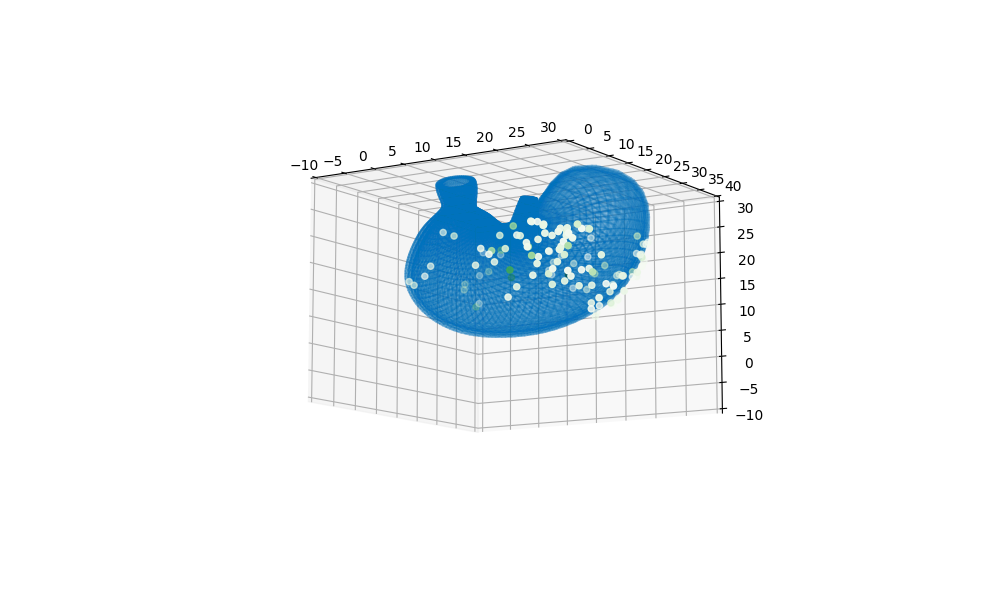

In [34]:
# this enables interactivity in jupyterlab and needs to be in the same cell as the plotting calls
%matplotlib widget 

# start a matplotlib 3d interactive figure
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

# add mesh as triangle polygons to 3d matplotlib view
faces = mplot3d.art3d.Poly3DCollection(your_mesh.vectors, color=(0, 0.4470, 0.7410))
faces.set_edgecolor((0, 0.4470, 0.7410, 0.1))
faces.set_alpha(0.1)
ax.add_collection3d(faces)

# plot the projected neurons coloured by their area of innervation
d = ax.scatter(data_threeDim[:,0], data_threeDim[:,1], data_threeDim[:,2], c=data_intensity, cmap='Greens')

# Scale view to the mesh size and turn off axis chrome
ax.set_xlim(0,40)
ax.set_ylim(-10,30)
ax.set_zlim(-10,30)

# ax.axis('off')
# ax.set_xlabel('x (mm)')
# ax.set_ylabel('y (mm)')
# ax.set_zlabel('z (mm)')

# cbar = fig.colorbar(d, pad=0.2, label=r"Area of innervation (um$^{2}$)",format='%.0e')

# show ventral surface and plot projected neurons
ax.view_init(-10, -57, 'y')
plt.show()